In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
DATA_DIR = Path(r"C:\Users\nikik\citibike_tripdata\citibike-dashboard\2022-citibike-tripdata")

In [3]:
csv_files = list(DATA_DIR.rglob("*.csv"))
len(csv_files)

38

In [4]:
usecols = ["started_at", "start_station_name", "member_casual"]

TARGET_N = 150_000      # total rows you want in the sample (adjust: 100k–500k)
CHUNKSIZE = 200_000     # chunk size while reading
take_per_chunk = 1_000  # rows sampled per chunk

samples = []
n = 0

for f in csv_files:
    for chunk in pd.read_csv(f, usecols=lambda c: c in usecols, chunksize=CHUNKSIZE, low_memory=False):
        chunk = chunk.dropna(subset=["start_station_name", "started_at"])
        if len(chunk) == 0:
            continue

        k = min(take_per_chunk, len(chunk), TARGET_N - n)
        if k <= 0:
            break

        samples.append(chunk.sample(n=k, random_state=42))
        n += k

        if n >= TARGET_N:
            break
    if n >= TARGET_N:
        break

bike_df = pd.concat(samples, ignore_index=True)

bike_df["started_at"] = pd.to_datetime(bike_df["started_at"], errors="coerce")
bike_df["date"] = bike_df["started_at"].dt.floor("D")

In [5]:
bike_df.shape

(150000, 4)

In [6]:
bike_df.columns

Index(['started_at', 'start_station_name', 'member_casual', 'date'], dtype='str')

In [7]:
# reading weather data
list(DATA_DIR.glob("*weather*"))

[WindowsPath('C:/Users/nikik/citibike_tripdata/citibike-dashboard/2022-citibike-tripdata/citibike_2022_with_weather.csv'),
 WindowsPath('C:/Users/nikik/citibike_tripdata/citibike-dashboard/2022-citibike-tripdata/laguardia_weather_2022_tavg.csv')]

In [8]:
weather_df = pd.read_csv(DATA_DIR / "laguardia_weather_2022_tavg.csv")

In [9]:
weather_df.head()

,date,tavg_c,station
0,2022-01-01,11.6,GHCND:USW00014732
1,2022-01-02,11.4,GHCND:USW00014732
2,2022-01-03,1.4,GHCND:USW00014732
3,2022-01-04,-2.7,GHCND:USW00014732
4,2022-01-05,3.2,GHCND:USW00014732


In [10]:
weather_df.columns

Index(['date', 'tavg_c', 'station'], dtype='str')

In [11]:
weather_df.shape

(365, 3)

In [12]:
weather_df["date"] = pd.to_datetime(weather_df["date"])

In [13]:
# setting a theme
sns.set_theme(style="whitegrid", palette="Blues")

In [14]:
# creating top 20 starting stations
top20 = (bike_df["start_station_name"].value_counts().head(20).reset_index())

top20.columns = ["start_station_name", "trips"]
top20

,start_station_name,trips
0,W 21 St & 6 Ave,644
1,Broadway & W 58 St,636
2,West St & Chambers St,617
3,1 Ave & E 68 St,552
4,6 Ave & W 33 St,537
5,Broadway & E 21 St,522
6,Broadway & W 25 St,514
7,Broadway & E 14 St,481
8,E 33 St & 1 Ave,478
9,Central Park S & 6 Ave,469


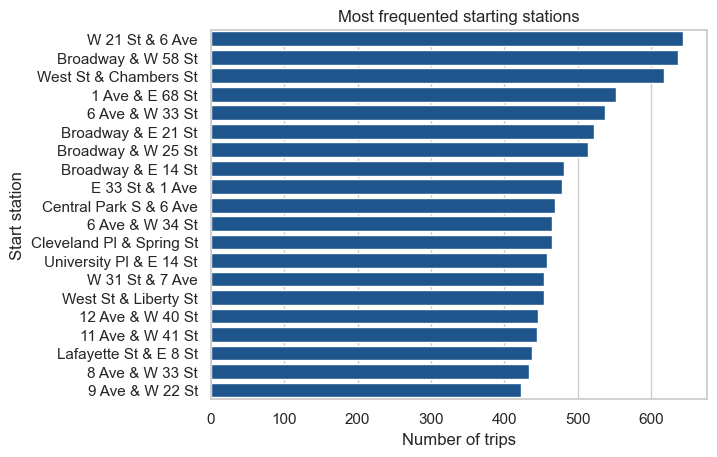

In [15]:
sns.set_palette("Blues_r")   # set palette explicitly

sns.barplot(
    data=top20,
    x="trips",
    y="start_station_name"
)

plt.title("Most frequented starting stations")
plt.xlabel("Number of trips")
plt.ylabel("Start station")
plt.show()

In [16]:
daily_trips = (bike_df.groupby("date").size().reset_index(name="bike_rides_daily"))

In [17]:
daily_trips.head()

,date,bike_rides_daily
0,2021-11-13,1
1,2021-12-31,1
2,2022-01-01,102
3,2022-01-02,240
4,2022-01-03,168


In [18]:
weather_df["date"] = pd.to_datetime(weather_df["date"])

weather_daily = weather_df[["date", "tavg_c"]].copy()

In [19]:
weather_daily.head()

,date,tavg_c
0,2022-01-01,11.6
1,2022-01-02,11.4
2,2022-01-03,1.4
3,2022-01-04,-2.7
4,2022-01-05,3.2


In [20]:
# merging data
df_temp = pd.merge(daily_trips,weather_daily,on="date",how="inner")

In [21]:
df_temp.head()

,date,bike_rides_daily,tavg_c
0,2022-01-01,102,11.6
1,2022-01-02,240,11.4
2,2022-01-03,168,1.4
3,2022-01-04,203,-2.7
4,2022-01-05,169,3.2


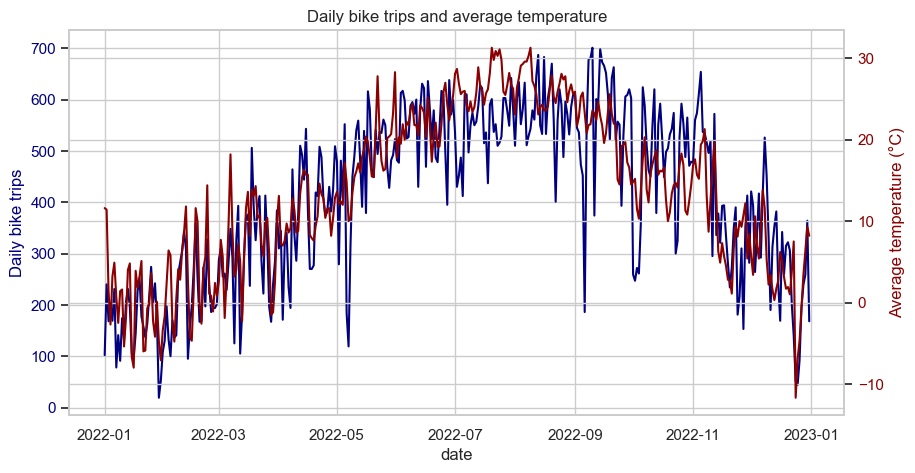

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bike trips line
sns.lineplot(
    data=df_temp,
    x="date",
    y="bike_rides_daily",
    ax=ax1,
    color="navy"
)
ax1.set_ylabel("Daily bike trips", color="navy")
ax1.tick_params(axis="y", labelcolor="navy")

# Second axis for temperature
ax2 = ax1.twinx()
sns.lineplot(
    data=df_temp,
    x="date",
    y="tavg_c",
    ax=ax2,
    color="darkred"
)
ax2.set_ylabel("Average temperature (°C)", color="darkred")
ax2.tick_params(axis="y", labelcolor="darkred")

plt.title("Daily bike trips and average temperature")
plt.show()

In [23]:
daily_user_trips = (bike_df .groupby(["date", "member_casual"]) .size() .reset_index(name="daily_trips"))

In [24]:
daily_user_trips.head()

,date,member_casual,daily_trips
0,2021-11-13,casual,1
1,2021-12-31,member,1
2,2022-01-01,casual,40
3,2022-01-01,member,62
4,2022-01-02,casual,68


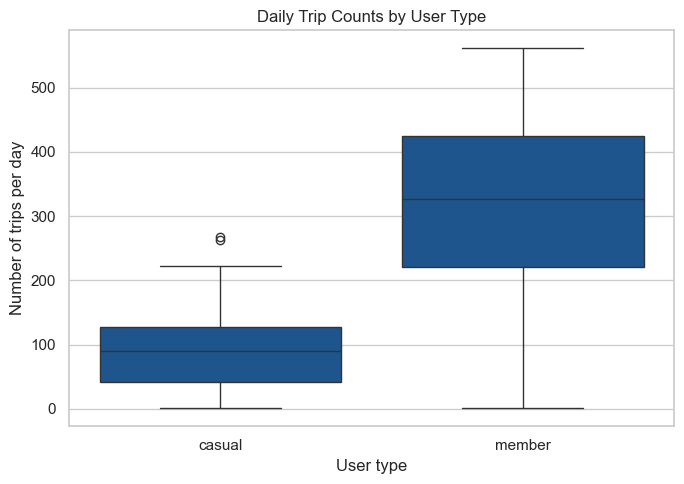

In [25]:
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=daily_user_trips,
    x="member_casual",
    y="daily_trips"
)

plt.title("Daily Trip Counts by User Type")
plt.xlabel("User type")
plt.ylabel("Number of trips per day")
plt.tight_layout()
plt.show()

# Box Plot analysis
The box plot shows a clear difference in daily trip counts between casual users and members. Member users have a much higher median number of daily trips and a wider interquartile range, indicating more frequent and consistent usage. In contrast, casual users have lower daily trip counts with a smaller spread and a few high outliers, suggesting occasional or event-driven usage. Overall, the results highlight that members contribute the majority of daily trips, likely reflecting regular commuting behavior, while casual usage is more variable.

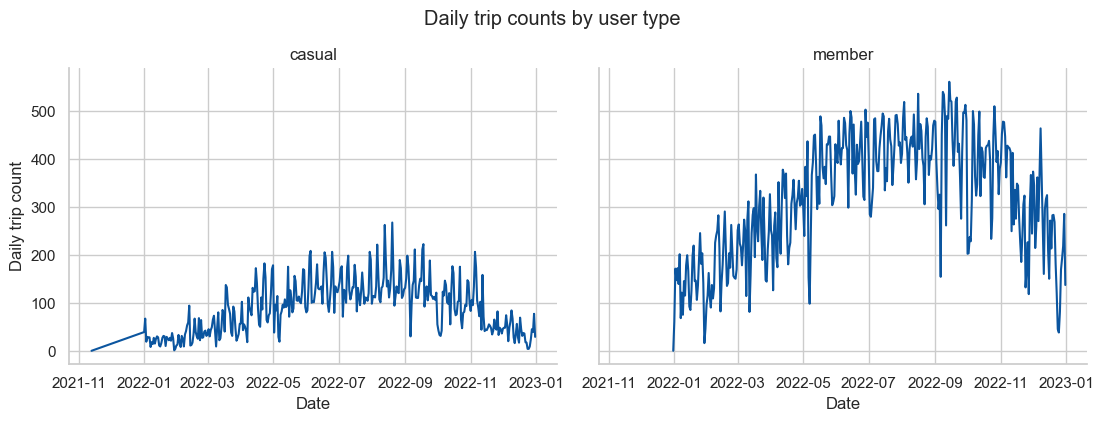

In [26]:
g = sns.FacetGrid(
    daily_user_trips,
    col="member_casual",
    height=4,
    aspect=1.4,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="date",
    y="daily_trips"
)

g.set_axis_labels("Date", "Daily trip count")
g.set_titles(col_template="{col_name}")
plt.suptitle("Daily trip counts by user type", y=1.05)
plt.show()

# Facetgird Analysis Interpretation
The FacetGrid shows daily trip counts over time separated by user type. Member users consistently record much higher daily trip counts than casual users throughout the year, indicating more regular and sustained usage. Seasonal variation is visible for both groups, with higher activity during warmer months and lower activity during winter. Casual usage remains comparatively low and sporadic, suggesting occasional or leisure-based trips, while member usage reflects routine or commuting behavior.